# Установка SimPy

In [1]:
%pip install -U simpy

## Первая модель

SimPy — это Python фреймворк для процессо-ориентированной дискретно-событийной системы моделирования. Он был разработан для создания асинхронных сетей и мультиагентных систем, как с моделируемым, так и с реальным взаимодействием.

In [2]:
# Импортировать библиотеку simpy
import simpy

In [3]:
# Функция выполнения операций по заявке
def order(env):

    # Выполнение

    print(f'{env.now:2.0f}, Мониторинг прибытия груж. конт.')
    yield env.timeout(10)

    print(f'{env.now:2.0f}, Добавление конт. в дисп. график')
    yield env.timeout(3)

    print(f'{env.now:2.0f}, Уведомление о прибытии конт. клиента')
    yield env.timeout(1)

In [5]:
# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# В среду выполнения помещаем процесс с заявкой
env.process(order(env))

# Запускаме моделирование на 100 минут
env.run(until=100)

 0, Мониторинг прибытия груж. конт.
10, Добавление конт. в дисп. график
13, Уведомление о прибытии конт. клиента


## Выполним три заявки

In [6]:
# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# В среду выполнения помещаем три процесса
p1 = env.process(order(env))
p2 = env.process(order(env))
p3 = env.process(order(env))

# Запускаме моделирование на 100 минут
env.run(until=50)

 0, Мониторинг прибытия груж. конт.
 0, Мониторинг прибытия груж. конт.
 0, Мониторинг прибытия груж. конт.
10, Добавление конт. в дисп. график
10, Добавление конт. в дисп. график
10, Добавление конт. в дисп. график
13, Уведомление о прибытии конт. клиента
13, Уведомление о прибытии конт. клиента
13, Уведомление о прибытии конт. клиента


## Доработаем заявку

In [8]:
def oper(env, order, oper, wait, dur):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполнение
    put = env.now # Время помещения в очередь
    yield env.timeout(dur)
    print(f'{put:2.0f}, {env.now:2.0f}, {order}, {oper} - {dur}')

def order(env, order, wait):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполняем операции
    yield env.process(oper(env, order, 'Мониторинг прибытия груж. конт.*', 0, 10))
    yield env.process(oper(env, order, 'Добавление конт. в дисп. график', 0, 30))
    yield env.process(oper(env, order, 'Уведомление о прибытии конт. клиента', 0, 5))

In [9]:
# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# В среду выполнения помещаем три процесса
p1 = env.process(order(env, "Заявка 1", 0))
p2 = env.process(order(env, "Заявка 2", 5))
p3 = env.process(order(env, "Заявка 3", 10))

# Запускаме моделирование на 100 минут
env.run(until=1440)

 0, 10, Заявка 1, Мониторинг прибытия груж. конт.* - 10
 5, 15, Заявка 2, Мониторинг прибытия груж. конт.* - 10
10, 20, Заявка 3, Мониторинг прибытия груж. конт.* - 10
10, 40, Заявка 1, Добавление конт. в дисп. график - 30
15, 45, Заявка 2, Добавление конт. в дисп. график - 30
40, 45, Заявка 1, Уведомление о прибытии конт. клиента - 5
20, 50, Заявка 3, Добавление конт. в дисп. график - 30
45, 50, Заявка 2, Уведомление о прибытии конт. клиента - 5
50, 55, Заявка 3, Уведомление о прибытии конт. клиента - 5


## Добавим ресурс


In [10]:
def oper(env, manager, order, oper, wait, dur):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполнение
    put = env.now # Время помещения в очередь
    with manager.request() as req: # Запрос особождения ресурса
        yield req              # Ждем осовбождение ресурса
        beg = env.now          # Начало выполнения
        delay = beg - put      # Задержка
        yield env.timeout(dur) # Время выполнения
        end = env.now          # Завершение выполнения
        print(f'{put:2.0f}, {beg:2.0f}, {end:2.0f}, {delay}, {len(manager.queue)}, {order}, {oper} - {dur}')

def order(env, manager, order, wait):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполняем операции
    yield env.process(oper(env, manager, order, 'Мониторинг прибытия груж. конт.*', 0, 10))
    yield env.process(oper(env, manager, order, 'Добавление конт. в дисп. график', 0, 30))
    yield env.process(oper(env, manager, order, 'Уведомление о прибытии конт. клиента', 0, 5))

In [14]:
# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# Создаем ресурс - менеджер
num_managers = 1 # число менеджеров (взимо заменяемых)
manager = simpy.PriorityResource(env, num_managers)

# В среду выполнения помещаем три процесса
p1 = env.process(order(env, manager, "Заявка 1", 0))
p2 = env.process(order(env, manager, "Заявка 2", 5))
p3 = env.process(order(env, manager, "Заявка 3", 10))

# Запускаме моделирование на 100 минут
env.run(until=1440)

 0,  0, 10, 0, 1, Заявка 1, Мониторинг прибытия груж. конт.* - 10
 5, 10, 20, 5, 2, Заявка 2, Мониторинг прибытия груж. конт.* - 10
10, 20, 30, 10, 2, Заявка 3, Мониторинг прибытия груж. конт.* - 10
10, 30, 60, 20, 2, Заявка 1, Добавление конт. в дисп. график - 30
20, 60, 90, 40, 2, Заявка 2, Добавление конт. в дисп. график - 30
30, 90, 120, 60, 2, Заявка 3, Добавление конт. в дисп. график - 30
60, 120, 125, 60, 2, Заявка 1, Уведомление о прибытии конт. клиента - 5
90, 125, 130, 35, 1, Заявка 2, Уведомление о прибытии конт. клиента - 5
120, 130, 135, 10, 0, Заявка 3, Уведомление о прибытии конт. клиента - 5


## Добавим логи

In [15]:
def oper(env, manager, order, oper, wait, dur):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполнение
    put = env.now # Время помещения в очередь
    with manager.request() as req: # Запрос особождения ресурса
        yield req              # Ждем осовбождение ресурса
        beg = env.now          # Начало выполнения
        delay = beg - put      # Задержка
        yield env.timeout(dur) # Время выполнения
        end = env.now          # Завершение выполнения
        #print(f'{put:2.0f}, {beg:2.0f}, {end:2.0f}, {delay}, {len(manager.queue)}, {order}, {oper} - {dur}')
        # Логи выполнения
        data_log.append([put, beg, end, delay, len(manager.queue), order, oper])

def order(env, manager, order, wait):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполняем операции
    yield env.process(oper(env, manager, order, '1. Мониторинг прибытия груж. конт.*', 0, 10))
    yield env.process(oper(env, manager, order, '2. Добавление конт. в дисп. график', 0, 30))
    yield env.process(oper(env, manager, order, '3. Уведомление о прибытии конт. клиента', 0, 5))

In [16]:
# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# Создаем ресурс - менеджер
num_managers = 1 # число менеджеров (взимо заменяемых)
manager = simpy.PriorityResource(env, num_managers)

# В среду выполнения помещаем три процесса
p1 = env.process(order(env, manager, "Заявка 1", 0))
p2 = env.process(order(env, manager, "Заявка 2", 5))
p3 = env.process(order(env, manager, "Заявка 3", 10))

# Лог
data_log = []

# Запускаме моделирование на 100 минут
env.run(until=1440)

# Печать лога
data_log

[[0, 0, 10, 0, 1, 'Заявка 1', '1. Мониторинг прибытия груж. конт.*'],
 [5, 10, 20, 5, 2, 'Заявка 2', '1. Мониторинг прибытия груж. конт.*'],
 [10, 20, 30, 10, 2, 'Заявка 3', '1. Мониторинг прибытия груж. конт.*'],
 [10, 30, 60, 20, 2, 'Заявка 1', '2. Добавление конт. в дисп. график'],
 [20, 60, 90, 40, 2, 'Заявка 2', '2. Добавление конт. в дисп. график'],
 [30, 90, 120, 60, 2, 'Заявка 3', '2. Добавление конт. в дисп. график'],
 [60, 120, 125, 60, 2, 'Заявка 1', '3. Уведомление о прибытии конт. клиента'],
 [90, 125, 130, 35, 1, 'Заявка 2', '3. Уведомление о прибытии конт. клиента'],
 [120, 130, 135, 10, 0, 'Заявка 3', '3. Уведомление о прибытии конт. клиента']]

## Научимся читать логи

Для это испольуем билиотеку pandas

In [17]:
import pandas as pd # библиотека для работы с данными
pd.DataFrame(data_log, columns=["put", "beg", "end", "delay", "queue", "order", "oper"])

,put,beg,end,delay,queue,order,oper
0,0,0,10,0,1,Заявка 1,1. Мониторинг прибытия груж. конт.*
1,5,10,20,5,2,Заявка 2,1. Мониторинг прибытия груж. конт.*
2,10,20,30,10,2,Заявка 3,1. Мониторинг прибытия груж. конт.*
3,10,30,60,20,2,Заявка 1,2. Добавление конт. в дисп. график
4,20,60,90,40,2,Заявка 2,2. Добавление конт. в дисп. график
5,30,90,120,60,2,Заявка 3,2. Добавление конт. в дисп. график
6,60,120,125,60,2,Заявка 1,3. Уведомление о прибытии конт. клиента
7,90,125,130,35,1,Заявка 2,3. Уведомление о прибытии конт. клиента
8,120,130,135,10,0,Заявка 3,3. Уведомление о прибытии конт. клиента


from matplotlib import pyplot as plt
_df_0['put'].plot(kind='hist', bins=20, title='put')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['beg'].plot(kind='hist', bins=20, title='beg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['end'].plot(kind='hist', bins=20, title='end')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['delay'].plot(kind='hist', bins=20, title='delay')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('order').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('oper').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='put', y='beg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='beg', y='end', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='end', y='delay', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='delay', y='queue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['put']
  ys = series['delay']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('put', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('order')):
  _plot_series(series, series_name, i)
  fig.legend(title='order', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('put')
_ = plt.ylabel('delay')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['put']
  ys = series['delay']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('put', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('oper')):
  _plot_series(series, series_name, i)
  fig.legend(title='oper', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('put')
_ = plt.ylabel('delay')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['put']
  ys = series['queue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('put', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('order')):
  _plot_series(series, series_name, i)
  fig.legend(title='order', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('put')
_ = plt.ylabel('queue')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['put']
  ys = series['queue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('put', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('oper')):
  _plot_series(series, series_name, i)
  fig.legend(title='oper', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('put')
_ = plt.ylabel('queue')

from matplotlib import pyplot as plt
_df_14['put'].plot(kind='line', figsize=(8, 4), title='put')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['beg'].plot(kind='line', figsize=(8, 4), title='beg')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['end'].plot(kind='line', figsize=(8, 4), title='end')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['delay'].plot(kind='line', figsize=(8, 4), title='delay')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['oper'].value_counts()
    for x_label, grp in _df_18.groupby('order')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('order')
_ = plt.ylabel('oper')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['order'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='put', y='order', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['oper'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='put', y='oper', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['order'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='beg', y='order', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['oper'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='beg', y='oper', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Построим график в ручную

Text(0.5, 1.0, 'Диаграмма Ганта')

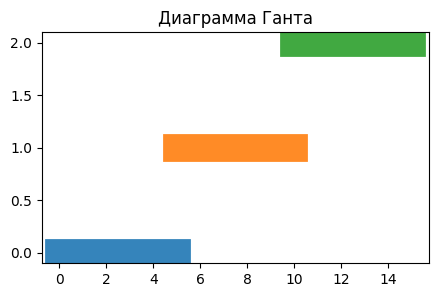

In [18]:
import matplotlib.pyplot as plt

# Создаим пустой график
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Добавим на график линии
ax.plot([0,5], [0, 0], lw=20, alpha=0.9)
ax.plot([5,10], [1, 1], lw=20, alpha=0.9)
ax.plot([10,15], [2, 2], lw=20, alpha=0.9)

# Подпишем
ax.set_title("Диаграмма Ганта")

## Построим график на основе данных

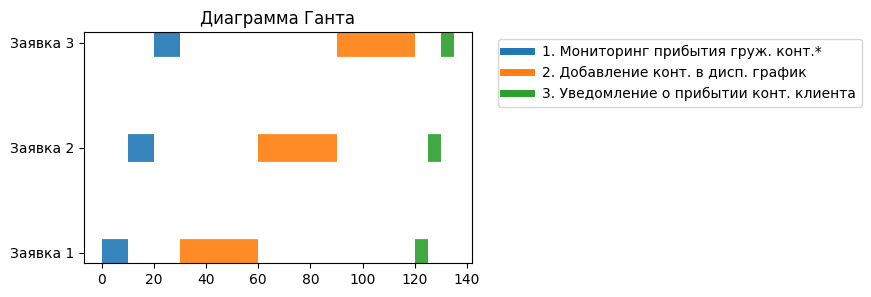

In [19]:
import numpy as np # линейная алгебра
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gant(df_data, lw=5, lh=3):

    # Добавлем колоноки в data_log
    df_data = pd.DataFrame(data_log, columns=["put", "beg", "end", "delay", "queue", "order", "oper"])
    df_data["index"] = df_data[["order", "oper"]].apply(lambda x: ", ".join(x), axis=1)

    ## Состави список заяок, операций
    orders = sorted(list(set(df_data["order"])))
    opers = sorted(list(set(df_data["oper"])))

    # Переичлим цвета для операций
    colors = []
    for i in enumerate(opers):
        colors.append(f"C{i[0]}")

    # Добавим график
    fig, ax = plt.subplots(1, 1, figsize=(lw, lh))

    # График с заявками
    for j, order in enumerate(orders): # для каждой заявки
        for i, oper in enumerate(opers): # для каждого события
            # Нанесем на график начальную и конечную точки операции
            for k in df_data[(df_data["order"]==order) & (df_data["oper"]==oper)].index:
                    ax.plot([df_data["beg"][k], df_data["end"][k]], [j, j],
                             colors[i], solid_capstyle="butt", lw=20, alpha=0.9)


    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(opers))]
    ax.legend(lines, opers, bbox_to_anchor=(1.05, 1.0), loc="upper left")

    ax.set_title("Диаграмма Ганта")
    ax.set_yticks(range(len(orders)))
    ax.set_yticklabels(orders)

gant(data_log)

## Добавим время

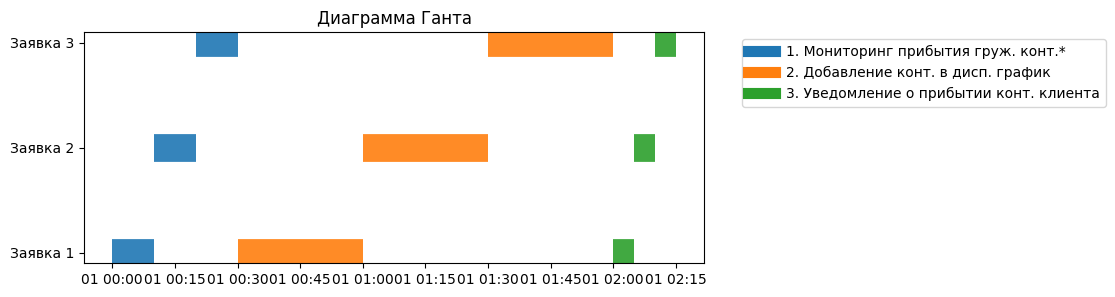

In [20]:
import numpy as np # линейная алгебра
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import HourLocator, DateFormatter
from matplotlib.lines import Line2D
from datetime import datetime

def gant(df_data, lw=8, lh=3):

    g = 0
    fig, ax = plt.subplots(1, 1, figsize=(lw, lh))

    # Добавлем колоноки в data_log
    df_data = pd.DataFrame(data_log, columns=["put", "beg", "end", "wait", "queue", "order", "oper"])

    # Добавим время
    df_data['t_put'] = pd.to_datetime((df_data['put']).astype('int'), unit='m')
    df_data['t_beg'] = pd.to_datetime((df_data['beg']).astype('int'), unit='m')
    df_data['t_end'] = pd.to_datetime((df_data['end']).astype('int'), unit='m')

    orders = sorted(list(set(df_data["order"])))
    opers = sorted(list(set(df_data["oper"])))

    colors = []
    for i in enumerate(opers):
        colors.append(f"C{i[0]}")

    lim_min = pd.to_datetime((df_data['beg'].min()), unit='m')
    lim_max = pd.to_datetime((df_data['beg'].max()), unit='m')

    # График с заявками
    for j, order in enumerate(orders): # для каждой заявки
        for i, oper in enumerate(opers): # для каждого события
            # Нанесем на график начальную и конечную точки
            for k in df_data[(df_data["order"]==order) & (df_data["oper"]==oper)].index:
                    ax.plot([df_data["t_beg"][k], df_data["t_end"][k]], [j, j],
                             colors[i], solid_capstyle="butt", lw=20, alpha=0.9)


    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(opers))]
    ax.legend(lines, opers, bbox_to_anchor=(1.05, 1.0), loc="upper left")

    ax.set_title("Диаграмма Ганта")
    ax.set_yticks(range(len(orders)))
    ax.set_yticklabels(orders)

gant(data_log)

## Пример со случаными величинами

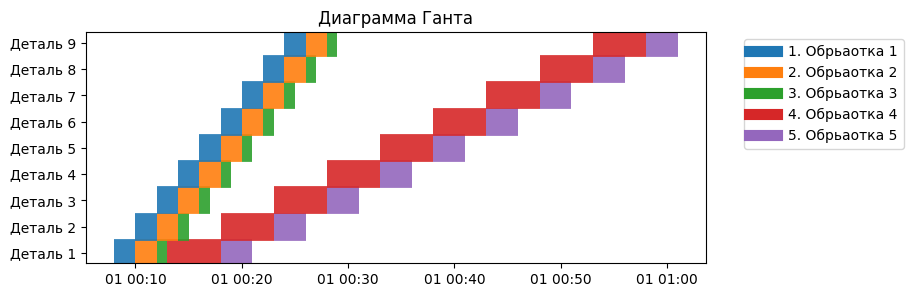

In [25]:
import random

def oper(env, res, order, oper, wait, dur):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполнение
    put = env.now # Время помещения в очередь
    with res.request() as req: # Запрос особождения ресурса
        yield req              # Ждем осовбождение ресурса
        beg = env.now          # Начало выполнения
        delay = beg - put      # Задержка
        yield env.timeout(dur) # Время выполнения
        end = env.now          # Завершение выполнения
        #print(f'{put:2.0f}, {beg:2.0f}, {end:2.0f}, {delay}, {len(res.queue)}, {order}, {oper} - {dur}')
        # Логи выполнения
        data_log.append([put, beg, end, delay, len(res.queue), order, oper])

def order(env, res, order, wait):
    # Ждем запуска
    yield env.timeout(wait)
    # Выполняем операции
    yield env.process(oper(env, res[0], order, '1. Обрьаотка 1', 0, ope[0]))
    yield env.process(oper(env, res[1], order, '2. Обрьаотка 2', 0, ope[1]))
    yield env.process(oper(env, res[2], order, '3. Обрьаотка 3', 0, ope[2]))
    yield env.process(oper(env, res[3], order, '4. Обрьаотка 4', 0, ope[3]))
    yield env.process(oper(env, res[4], order, '5. Обрьаотка 5', 0, ope[4]))

# Иницилизация среды выпполнения имитационной модели
env = simpy.Environment(initial_time=0)

# Создаем ресурс - менеджер
r1 = simpy.PriorityResource(env, random.randint(1, 3))
r2 = simpy.PriorityResource(env, random.randint(1, 3))
r3 = simpy.PriorityResource(env, random.randint(1, 3))
r4 = simpy.PriorityResource(env, random.randint(1, 3))
r5 = simpy.PriorityResource(env, random.randint(1, 3))
res = [r1, r2, r3, r4, r5]
ope = [random.randint(1, 10), random.randint(1, 10), random.randint(1, 10), random.randint(1, 10), random.randint(1, 10)]

n = 9
d = random.randint(5, 10)

# В среду выполнения помещаем три процесса
for i in range(n):

    p1 = env.process(order(env, res, f"Деталь {i+1}", d))

# Лог
data_log = []

# Запускаме моделирование на 100 минут
env.run(until=500)

# Печать лога
#data_log

gant(data_log)